In [6]:
import sys
import os
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import ast

In [41]:
# Parameters
current_directory = os.getcwd()

# Name of the model to be evaluated
model_name = 'AgeRecognitionModel.keras'

# Name of the directory in which files with test results will be saved
evaluation_directory_name = 'eval-test'

# Path to the directory where txt files with results will be saved
evaluation_directory_path = os.path.join(current_directory, evaluation_directory_name)

# Name of the file with the data for each image
eval_file_name = 'evaluation.txt'

# Name of the file with the result data
result_file_name = 'result.txt'

# Path to the folder containing images to be used for testing purposes
images_path = 'C:\\Users\\Adrian\\source\\Python\\images\\rashi'

# Parameter defining whether model predicted age accurately - absolute value of difference between labelled age and predicted age
accuracy_param = 7

# Parameter defining whether the accuracy should be checked in relation to the percentage difference or difference between labelled age and predicted age
accuracy_in_percentage = False

# Size of the age group, ex. for age_group_size = 10, the age groups will be [0-9, 10-19, ...] 
age_group_size = 10

# Name of the residuals histogram
residual_histogram_name = 'residuals_histogram.png'

# Name of the plots to be saved
rmse_plot_name = 'RMSE.png'
mape_plot_name = 'MAPE.png'
count_plot_name = 'Count.png'
accuracy_plot_name = 'Accuracy.png'

In [8]:
# Load the pre-trained model
model_path = os.path.join(current_directory, model_name)
model = load_model(model_path)

# Residuals
residuals = []

In [9]:
# Defining used functions

def create_directory(path, eval_file_name, result_file_name):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory at path: {path}")
    
    eval_file_path = os.path.join(path, eval_file_name)
    if os.path.exists(eval_file_path):
        try:
            with open(eval_file_path, 'w') as new_file:
                pass
        except Exception as e:
            print(f"An error occurred: {e}")
            
    result_file_path = os.path.join(path, result_file_name)
    if os.path.exists(result_file_path):
        try:
            with open(result_file_path, 'w') as new_file:
                pass
        except Exception as e:
            print(f"An error occurred: {e}")

def write_to_text_file(dir_path, file_name, content):
    file_path = os.path.join(dir_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'a') as file:
            file.write(content + '\n')
    else:
        with open(file_path, 'w') as file:
            file.write(content + '\n')

def get_image_features(image_path):
    img = image.load_img(image_path, grayscale=True)
    img = img.resize((128, 128), Image.LANCZOS)
    img = image.img_to_array(img)
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0
    return img

# specific logic for data from: https://www.kaggle.com/datasets/rashikrahmanpritom/age-recognition-dataset
# or other images that contains labelled age in the format: AGE_x_y_z.jpg (age must be in the first index separated by '_' sign)
def eval_image(image_file, dir_path, model, eval_dir, accuracy_param):
    img = get_image_features(os.path.join(dir_path, image_file))

    predictions = model.predict(img)
    age = round(predictions[0][0])

    splitted_text = image_file.split('_')
    labelled_age = int(splitted_text[0])
    difference = abs(labelled_age - age)
    percent_difference = abs(int(difference)) / labelled_age * 100
    is_accurate = round(percent_difference) <= accuracy_param if accuracy_in_percentage else round(difference) <= accuracy_param

    eval_file_name = 'evaluation.txt'
    obj = {
        'Model': age,
        'Label': labelled_age,
        'Difference': difference,
        'PercentageDifference': round(percent_difference),
        'Accurate': is_accurate
    }
    labeled_age = obj['Label']
    predicted_age = obj['Model']
    residuals.append(labeled_age - predicted_age)
    write_to_text_file(eval_dir, eval_file_name, str(obj))

def test_images(directory_path, model, eval_dir, accuracy_param):
    if not os.path.exists(directory_path) or not os.path.isdir(directory_path):
        print(f"The specified path '{directory_path}' is not a valid directory.")
        return
    
    files = os.listdir(directory_path)
    
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No image files found in '{directory_path}'.")
        return
    
    for image_file in image_files:
        try:
            eval_image(image_file, directory_path, model, eval_dir, accuracy_param)
        except Exception as e:
            print(f"Error processing {image_file}. Reason: {e}")

def read_residuals(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    results = [ast.literal_eval(line.strip()) for line in lines]
    # Calculate residuals and append to the list
    residuals = []
    for result in results:
        labeled_age = result['Label']
        predicted_age = result['Model']
        residuals.append(labeled_age - predicted_age)
    return residuals

In [43]:
def plot_residual_histogram(residuals, save_path=None):
    #plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residuals Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Count')

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def analyze_and_visualize_data(eval_dir, file_path, residuals):
    data_file = os.path.join(eval_dir, file_path)
    if not os.path.exists(data_file):
        print(f'There is no such a file at the path: {data_file}')
        print('Run test_images in order to evaluate the dataset')
        return
    
    with open(data_file, 'r') as file:
        lines = file.readlines()

    data_str = ''.join(lines).replace('\n', ',')

    data_list = eval('[' + data_str + ']')

    df = pd.DataFrame(data_list)

    # Calculate RMSE and MAPE for all data in the dataset
    rmse_all = np.sqrt(mean_squared_error(df['Label'], df['Model']))
    mape_all = np.mean(np.abs((df['Model'] - df['Label']) / df['Label'])) * 100

    print("RMSE for all data:", rmse_all)
    print("MAPE for all data:", mape_all)

    age_ranges = list(range(0, 111, age_group_size))
    age_labels = [f"{start}-{start+age_group_size-1}" for start in age_ranges[:-1]]

    df['AgeGroup'] = pd.cut(df['Label'], bins=age_ranges, labels=age_labels, right=False)

    rmse_groups = []
    mape_groups = []

    for age_group in age_labels:
        group = df[df['AgeGroup'] == age_group]

        if group.empty:
            rmse_groups.append(0)
            mape_groups.append(0)
            continue

        rmse_group = np.sqrt(mean_squared_error(group['Label'], group['Model']))
        mape_group = np.mean(np.abs((group['Model'] - group['Label']) / group['Label'])) * 100
        rmse_groups.append(rmse_group)
        mape_groups.append(mape_group)
        print(f"\nRMSE for age group {age_group}:", rmse_group)
        print(f"MAPE for age group {age_group}:", mape_group)

    count_per_age_group = df['AgeGroup'].value_counts().sort_index()

    correct_predictions = df[df['Accurate'] == True].shape[0]
    total_predictions = df.shape[0]
    accuracy = correct_predictions / total_predictions * 100

    print("\nAccuracy:", accuracy, "%")

    results_dict = {
        'RMSE_all': rmse_all,
        'MAPE_all': mape_all,
        'RMSE_groups': rmse_groups,
        'MAPE_groups': mape_groups,
        'Accuracy': accuracy
    }

    result_file_path = os.path.join(eval_dir, result_file_name)
    with open(result_file_path, 'w') as results_file:
        results_file.write(str(results_dict))

    labels = [str(age_group) for age_group in age_labels]

    # Plot and save the residuals histogram
    if not residuals:
        residuals_file_path = os.path.join(eval_dir, eval_file_name)
        if not os.path.exists(residuals_file_path):
            print(f"Error with file at path: {residuals_file_path}")
            print("There is no file containing data for each image. Run test_images")
            return
        
        residuals = read_residuals(residuals_file_path)
    histogram_save_path = os.path.join(eval_dir, residual_histogram_name)
    if not os.path.exists(eval_dir):
        print('Path to save the RMSE & MAPE plot is not proper')
        return
    plot_residual_histogram(residuals, save_path=histogram_save_path)

    plt.figure(figsize=(8, 6))

    # RMSE plot for age groups
    #plt.subplot(1, 2, 1)
    plt.bar(labels, rmse_groups, color='blue')
    plt.title('RMSE for Age Groups')
    plt.xlabel('Age Groups')
    plt.ylabel('RMSE')
    plot_image_path = os.path.join(eval_dir, rmse_plot_name)
    if not os.path.exists(eval_dir):
        print('Path to save the RMSE plot is not proper')
        return
    plt.savefig(plot_image_path)
    plt.show()

    # MAPE plot for age groups
    plt.figure(figsize=(8, 6))
    plt.bar(labels, mape_groups, color='orange')
    plt.title('MAPE for Age Groups')
    plt.xlabel('Age Groups')
    plt.ylabel('MAPE')
    plot_image_path = os.path.join(eval_dir, mape_plot_name)
    if not os.path.exists(eval_dir):
        print('Path to save the MAPE plot is not proper')
        return
    plt.savefig(plot_image_path)
    plt.show()

    # Number of people in each age group plot
    plt.figure(figsize=(8, 6))
    plt.bar(count_per_age_group.index, count_per_age_group.values, color='gray')
    plt.title('Number of Observations in Each Age Group')
    plt.xlabel('Age Groups')
    plt.ylabel('Count')
    plot_image_path = os.path.join(eval_dir, count_plot_name)
    if not os.path.exists(eval_dir):
        print('Path to save the Count plot is not proper')
        return
    plt.savefig(plot_image_path)
    plt.show()

    # Accuracy pie plot
    plt.figure(figsize=(8, 6))
    plt.pie([correct_predictions, total_predictions - correct_predictions], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['green', 'red'])
    plt.title(f'Accuracy of Predictions for param: {accuracy_param}')

    plt.tight_layout()

    plot_image_path = os.path.join(eval_dir, accuracy_plot_name)
    if not os.path.exists(eval_dir):
        print('Path to save the Accuracy plot is not proper')
        return
    plt.savefig(plot_image_path)

    plt.show()

In [173]:

# Create directory or remove its content to save data
create_directory(evaluation_directory_path, eval_file_name, result_file_name)
# Evaluate test images using provided model 
test_images(images_path, model, evaluation_directory_path, accuracy_param)

1/1 [==============================] - 0s 109ms/step


c:\Users\Patryk\source\Python\AgeRecognition\my_env\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


RMSE for all data: 9.89295237835857
MAPE for all data: 24.50420573662253

RMSE for age group 0-9: 8.331902595348142
MAPE for age group 0-9: 80.39603061062289

RMSE for age group 10-19: 7.137906280868441
MAPE for age group 10-19: 38.99204418741822

RMSE for age group 20-29: 5.135014813814005
MAPE for age group 20-29: 14.58001439294147

RMSE for age group 30-39: 5.349560827499807
MAPE for age group 30-39: 14.223385689354275

RMSE for age group 40-49: 9.47484875131628
MAPE for age group 40-49: 17.191142237621772

RMSE for age group 60-69: 12.744810601518909
MAPE for age group 60-69: 15.74522340538757

RMSE for age group 70-79: 14.752366993222415
MAPE for age group 70-79: 15.626019179938066

RMSE for age group 80-89: 16.68023257422266
MAPE for age group 80-89: 15.784682940258696

RMSE for age group 90-99: 20.547772081177072
MAPE for age group 90-99: 17.74344506384969

Accuracy: 65.39518522589864 %


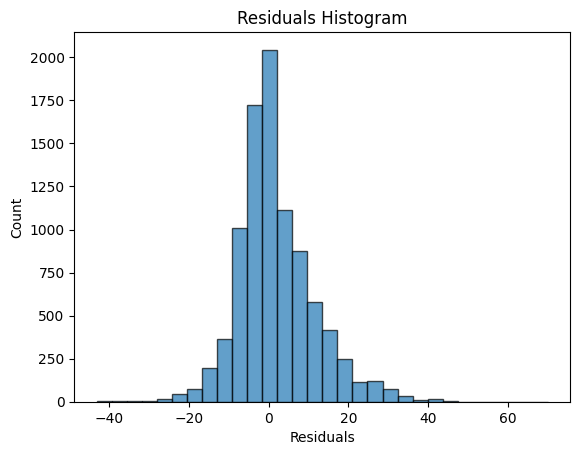

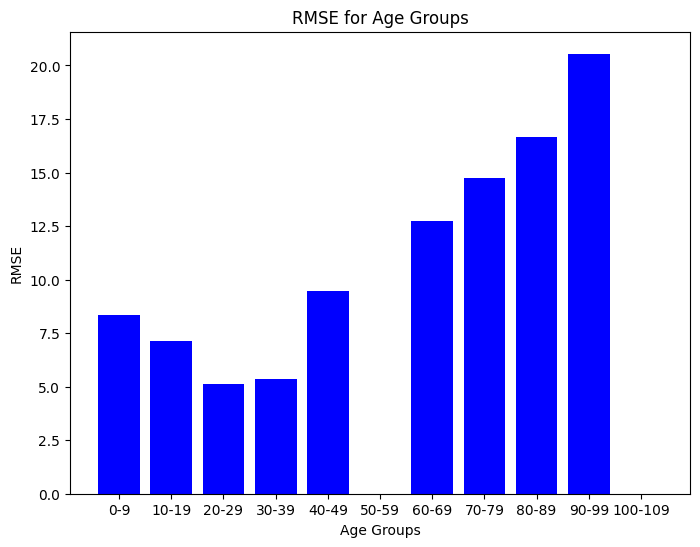

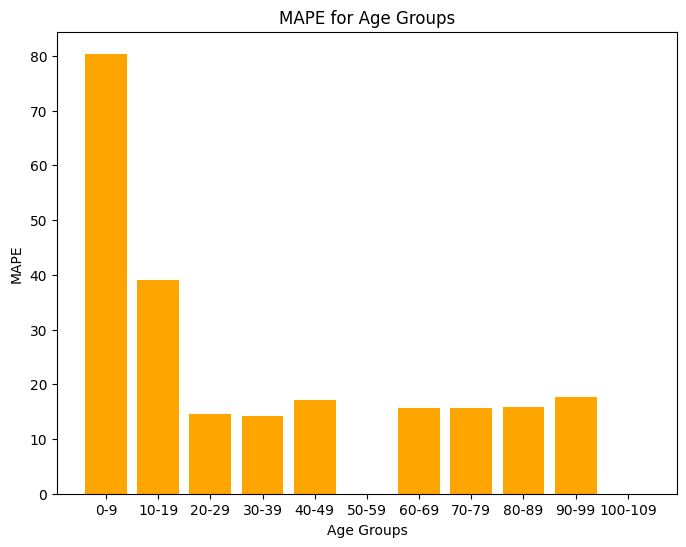

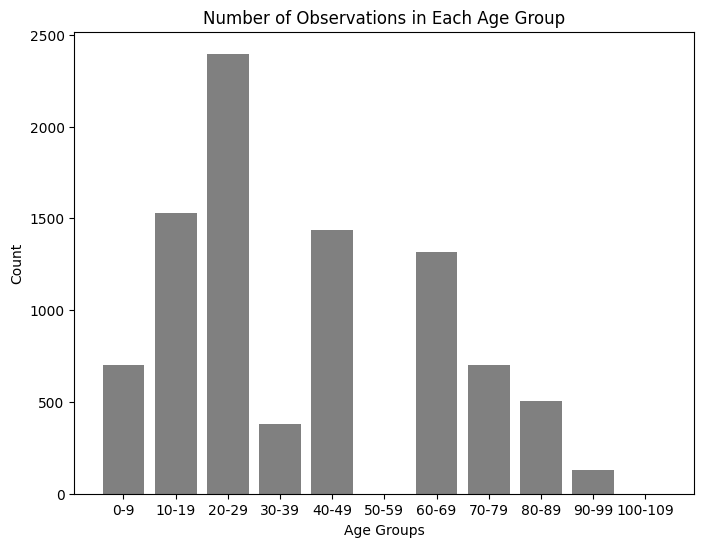

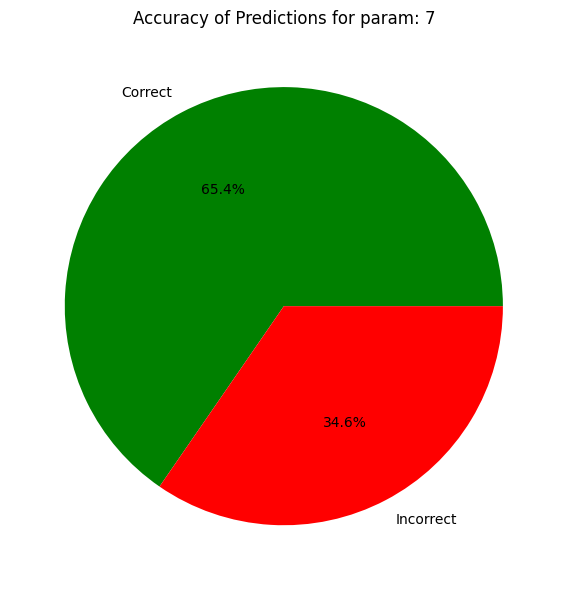

In [44]:
# Analyze and visualize data from the file located at evaluation_directory_path/eval_file_name
analyze_and_visualize_data(evaluation_directory_path, eval_file_name, residuals)